# Notebook for calculating correlations from .h5 files and average them

## Insert folder name containing the .h5 files to analyze. 

In [1]:
FolderName = r'X:\ScanningConfocal\Han\20190517-Alexa546.5nM,28.30uW.sptw\Alexa546. 50nM. 24.88uW2'

## Give a name for these data. 

In [2]:
name = r'Alexa546 50nM PBS 24.9µW green'

## What do you want to correlate?

### Possiblities are: 'donor', 'acceptor','cross'

In [3]:
Channel = 'donor'

## Loading standard things, do not change

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import optimize
from fretbursts import *
import pycorrelate as pyc
plt.style.use('seaborn-talk')

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


## Find number .h5 of files in folder

In [6]:
for file in os.listdir(FolderName):
    if file.endswith('.h5'):
        FileList = [os.path.join(FolderName, f) for f in os.listdir(FolderName) if f.endswith('.h5')]

## Calculating the auto-correlations for each file and the average correlation

In [7]:
#Creating delay times in number of microtime units
n_group = 5
bin_widths = []
for i in range(22):
    bin_widths += [2**i]*n_group
np.array(bin_widths)
bins = np.hstack(([0], np.cumsum(bin_widths)))[8:]
timestamps_unit=50e-9

G = np.zeros((len(bins)-1,len(FileList)))
Brightness=np.zeros(len(FileList))
index=0

for i in FileList:
        data = loader.photon_hdf5(i)
        #data.add(det_donor_accept = (2, 0), alex_period = 4000, offset = 0, D_ON = (2, 4000), A_ON = (0, 1))
        loader.alex_apply_period(data)
        if Channel == 'donor':
            FCS=data.get_ph_times(ph_sel=Ph_sel(Aex='Dem'))   # Time stamps donor excitation, donor emission
            Brightness[index]=np.size(FCS)/data.time_max
            G_temp = pyc.pcorrelate(FCS,FCS, bins, normalize=True)-1
            G[:,index]=G_temp
            index = index + 1
        elif Channel == 'acceptor':
            FCS=data.get_ph_times(ph_sel=Ph_sel(Aex='Aem'))   # Time stamps acceptor excitation, acceptor emission
            Brightness[index]=np.size(FCS)/data.time_max
            G_temp = pyc.pcorrelate(FCS,FCS, bins, normalize=True)-1
            G[:,index]=G_temp
            index = index + 1
        elif Channel == 'cross':
            FCS_donor=data.get_ph_times(ph_sel=Ph_sel(Aex='Dem'))   # Time stamps donor excitation, donor emission
            FCS_acceptor=data.get_ph_times(ph_sel=Ph_sel(Aex='Aem'))   # Time stamps acceptor excitation, acceptor emission
            Brightness[index]=np.size(FCS_donor)/data.time_max
            G_temp = pyc.pcorrelate(FCS_donor,FCS_acceptor, bins, normalize=True)-1
            G[:,index]=G_temp
            index = index + 1
    
averageFCS=np.mean(G,axis=1)
averageBrightness=np.mean(Brightness)

# Total photons (after ALEX selection):     8,924,587
#  D  photons in D+A excitation periods:    8,924,587
#  A  photons in D+A excitation periods:            0
# D+A photons in  D  excitation period:        12,896
# D+A photons in  A  excitation period:     8,911,691

# Total photons (after ALEX selection):     8,961,525
#  D  photons in D+A excitation periods:    8,961,525
#  A  photons in D+A excitation periods:            0
# D+A photons in  D  excitation period:        12,965
# D+A photons in  A  excitation period:     8,948,560

# Total photons (after ALEX selection):     8,949,810
#  D  photons in D+A excitation periods:    8,949,810
#  A  photons in D+A excitation periods:            0
# D+A photons in  D  excitation period:        12,810
# D+A photons in  A  excitation period:     8,937,000

# Total photons (after ALEX selection):     8,968,264
#  D  photons in D+A excitation periods:    8,968,264
#  A  photons in D+A excitation periods:            0
# D+A photons in  D  exci

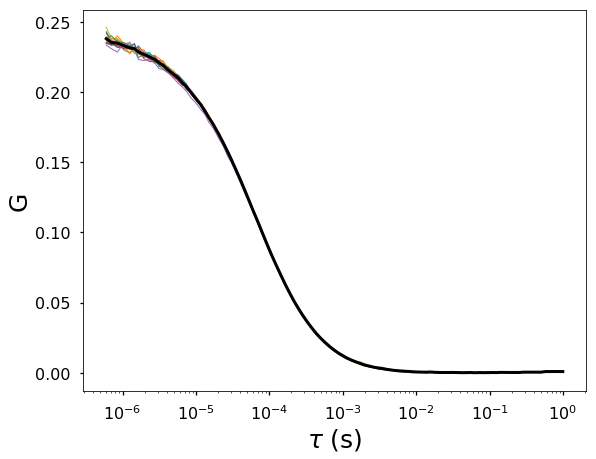

In [12]:
fig, ax = plt.subplots(figsize=(9,7))
ax.semilogx(np.mean([bins[1:], bins[:-1]], 0)*timestamps_unit,G,linewidth=1,label='Correlation')
ax.semilogx(np.mean([bins[1:], bins[:-1]], 0)*timestamps_unit,averageFCS,color='black',linewidth=3,label='Average correlation')

ax.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax.set_ylabel(r'G',fontsize=25)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

#ax.legend()

plt.show()

# Fitting correlation curves

In [13]:
#Standard model, only considering diffusion
def FCS(t, Nmol, difftime, kappa):
    return (1/Nmol) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa**2)*difftime)))**(-0.5)

In [14]:
#Extended model where a triplet fraction is included
def FCSTrip(t, N, difftime, kappa, Tfrac, triptime):
    return (1/N) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa**2)*difftime)))**(-0.5) * ((1 - Tfrac + Tfrac * np.exp(-(t/triptime))/(1-Tfrac)))

In [15]:
#Fitting the average correlation curve
xdataFCS=np.mean([bins[1:], bins[:-1]], 0)*timestamps_unit

#We only use the diffusion with triplet
paramsFCS, params_covarianceFCS = optimize.curve_fit(FCSTrip, xdataFCS, averageFCS, p0=[np.round(1/averageFCS[0]),100e-6,10,0.1,10e-6],method='lm')
print(paramsFCS)

print('Brightness =')
print(np.round(averageBrightness/paramsFCS[0]))

#Output format:
#Triplet [Number of particles in confocal volume, Diffusion time (s), Aspect ratio, Triplet fraction, Triplet time (ms)]

[4.17697112e+00 6.63761750e-05 7.62745246e+00 6.95587389e-02
 4.53018380e-06]
Brightness =
35987.0


In [69]:
import matplotlib.gridspec as gridspec

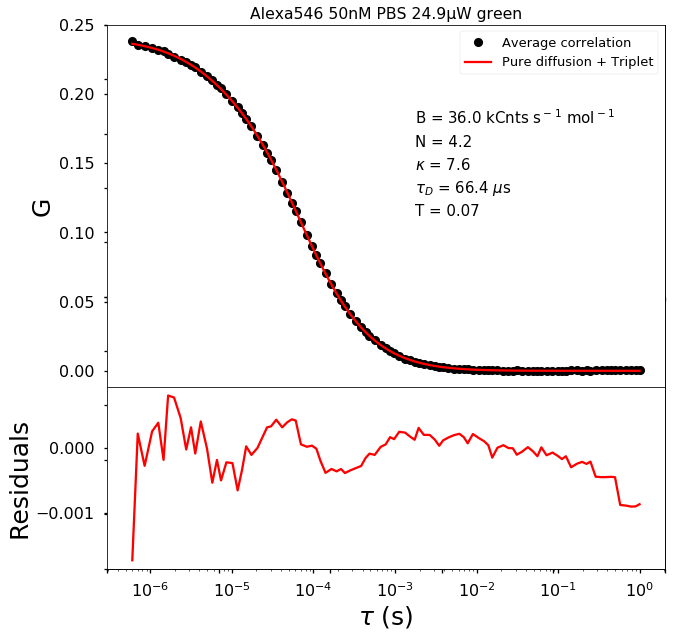

In [100]:
figure1, (ax1, ax2) = plt.subplots(2, sharex=True,sharey=True,figsize=(10,10))
gs = gridspec.GridSpec(3, 1, figure=figure1)


#Plot the FCS data and fit
ax1= figure1.add_subplot(gs[:2, 0])
ax1.semilogx(xdataFCS, averageFCS, 'o', label='Average correlation',color='black')
ax1.semilogx(xdataFCS,FCSTrip(xdataFCS, paramsFCS[0], paramsFCS[1],paramsFCS[2], paramsFCS[3], paramsFCS[4]),
         label='Pure diffusion + Triplet',color='red')

ax1.set_ylabel(r'G',fontsize=25)
ax1.yaxis.set_tick_params(labelsize=16)

ax1.text(10**(-2.75), 0.75*averageFCS[0], r'B = '+str(np.round(0.001*averageBrightness/paramsFCS[0]))+' kCnts s$^-$$^1$ mol$^-$$^1$', fontsize=15)
ax1.text(10**(-2.75), 0.68*averageFCS[0], r'N = '+ str(np.round(paramsFCS[0],1)), fontsize=15)
ax1.text(10**(-2.75), 0.61*averageFCS[0], r'$\kappa$ = '+ str(np.round(np.absolute(paramsFCS[2]),1)), fontsize=15)
ax1.text(10**(-2.75), 0.54*averageFCS[0], r'$\tau$$_D$ = '+ str(np.round(paramsFCS[1]*10**6,1))+' $\mu$s', fontsize=15)
ax1.text(10**(-2.75), 0.47*averageFCS[0], r'T = '+ str(np.round(paramsFCS[3],2)), fontsize=15)

ax1.set_title(name)
ax1.legend()


#Plot the residuals
ax2= figure1.add_subplot(gs[2, 0])
ax2.semilogx(xdataFCS,(FCSTrip(xdataFCS, paramsFCS[0], paramsFCS[1],paramsFCS[2], paramsFCS[3], paramsFCS[4])-averageFCS),
         label='Pure diffusion + Triplet',color='Red')


ax2.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax2.set_ylabel(r'Residuals',fontsize=25)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

figure1.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in figure1.axes[:-1]], visible=False)
plt.setp([a.get_yticklabels() for a in figure1.axes[:-2]], visible=False)

plt.show()

In [24]:
#Save the figure as a pdf
figure1.savefig(name + '.pdf')

# SPECIAL: Fitting with structural parameter fixed

In [102]:
kappa_fixed = 8

In [103]:
#Standard model, only considering diffusion
def FCSfixed(t, Nmol, difftime):
    return (1/Nmol) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa_fixed**2)*difftime)))**(-0.5)

In [104]:
#Extended model where a triplet fraction is included
def FCSTripfixed(t, N, difftime, Tfrac, triptime):
    return (1/N) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa_fixed**2)*difftime)))**(-0.5) * ((1 - Tfrac + Tfrac * np.exp(-(t/triptime))/(1-Tfrac)))

In [105]:
#Fitting the average correlation curve
xdataFCS=np.mean([bins[1:], bins[:-1]], 0)*timestamps_unit

#We only use the diffusion with triplet
paramsFCSfixed, params_covarianceFCSfixed = optimize.curve_fit(FCSTripfixed, xdataFCS, averageFCS, p0=[np.round(1/averageFCS[0]),100e-6,0.1,10e-6],method='lm')
print(paramsFCSfixed)

print('Brightness =')
print(np.round(averageBrightness/paramsFCSfixed[0]))

#Output format:
#Triplet [Number of particles in confocal volume, Diffusion time (s), Aspect ratio, Triplet fraction, Triplet time (ms)]

[4.17553178e+00 6.60761106e-05 6.88383751e-02 4.43044199e-06]
Brightness =
36000.0


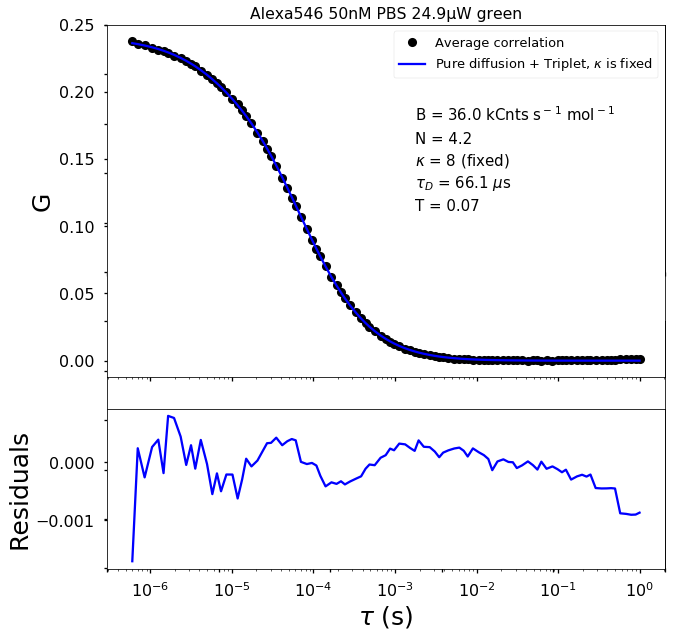

In [110]:
figure2, (ax1, ax2) = plt.subplots(2, sharex=True,sharey=True,figsize=(10,10))
gs = gridspec.GridSpec(3, 1, figure=figure2)

#Plot the FCS data and fit
ax1= figure2.add_subplot(gs[:2, 0])
ax1.semilogx(xdataFCS, averageFCS, 'o', label='Average correlation',color='black')
ax1.semilogx(xdataFCS,FCSTripfixed(xdataFCS, paramsFCSfixed[0], paramsFCSfixed[1],paramsFCSfixed[2], paramsFCSfixed[3]),
         label='Pure diffusion + Triplet, $\kappa$ is fixed',color='blue')

ax1.set_ylabel(r'G',fontsize=25)
ax1.yaxis.set_tick_params(labelsize=16)

#Add parameters to plot
ax1.text(10**(-2.75), 0.75*averageFCS[0], r'B = '+str(np.round(0.001*averageBrightness/paramsFCSfixed[0]))+' kCnts s$^-$$^1$ mol$^-$$^1$', fontsize=15)
ax1.text(10**(-2.75), 0.68*averageFCS[0], r'N = '+ str(np.round(paramsFCSfixed[0],1)), fontsize=15)
ax1.text(10**(-2.75), 0.61*averageFCS[0], r'$\kappa$ = '+ str(kappa_fixed)+' (fixed)', fontsize=15)
ax1.text(10**(-2.75), 0.54*averageFCS[0], r'$\tau$$_D$ = '+ str(np.round(paramsFCSfixed[1]*10**6,1))+' $\mu$s', fontsize=15)
ax1.text(10**(-2.75), 0.47*averageFCS[0], r'T = '+ str(np.round(paramsFCSfixed[2],2)), fontsize=15)

ax1.set_title(name)
ax1.legend()


#Plot the residuals
ax2= figure2.add_subplot(gs[2, 0])
ax2.semilogx(xdataFCS,FCSTripfixed(xdataFCS, paramsFCSfixed[0], paramsFCSfixed[1],paramsFCSfixed[2], paramsFCSfixed[3])-averageFCS,
         label=r'Pure diffusion + Triplet fixed $\kappa$',color='blue')


ax2.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax2.set_ylabel(r'Residuals',fontsize=25)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

figure1.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in figure2.axes[:-1]], visible=False)
plt.setp([a.get_yticklabels() for a in figure2.axes[:-2]], visible=False)

plt.show()

In [99]:
#Save the figure as a pdf
figure2.savefig(name + '.pdf')